## Import libs

In [1]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util import metrics

from madras_laftr.models import *

## Preliminaries

In [2]:
batch_size = 64
epochs = 1000
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
CLAS_COEFF = 1.
FAIR_COEFF = 1.
RECON_COEFF = 0.
hidden_layer_specs = {'clas':[8] , 'enc':[8] , 'dec':[8] , 'adv':[8]}

## Load data

In [3]:
data_folder = Path(r'/home/luiz/ufpb/mestrado/code/falsb/data/adult')

In [4]:
train_file = data_folder/r'post_prep/adult_train.csv'
train_data = np.genfromtxt(train_file, delimiter=',')

In [5]:
num_examples = train_data.shape[0]

In [6]:
x_train, y_train, a_train = train_data[:-10,:-1], train_data[:-10,-1].reshape((num_examples-10, 1)), train_data[:-10,-2].reshape((num_examples-10, 1)) #-10 to do consider only perfect batchs

In [7]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]
zdim = 8

In [8]:
x_train.shape

(24128, 113)

In [9]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size)
train_data

<BatchDataset shapes: ((None, 113), (None, 1), (None, 1)), types: (tf.float64, tf.float64, tf.float64)>

In [10]:
valid_file = data_folder/r'post_prep/adult_valid.csv'
valid_data = np.genfromtxt(valid_file, delimiter=',')

num_examples = valid_data.shape[0]

x_valid, y_valid, a_valid = valid_data[:-8,:-1], valid_data[:-8,-1].reshape((num_examples-8, 1)), valid_data[:-8,-2].reshape((num_examples-8, 1))
valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size)

In [11]:
test_file = data_folder/r'post_prep/adult_test.csv'
test_data = np.genfromtxt(test_file, delimiter=',')

num_examples = test_data.shape[0]

x_test, y_test, a_test = test_data[:,:-1], test_data[:,-1].reshape((num_examples, 1)), test_data[:,-2].reshape((num_examples, 1))
test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size)

## Train loop

In [12]:
def train(model, X, Y, A, optimizer, learning_rate=0.001):
    
    '''training enc-clas-dec'''
   
    enc_clas_dec = model.enc.variables + model.clas.variables + model.dec.variables
    adv = model.adv.variables

    with tf.GradientTape() as tape_min:
        
        tape_min.watch(enc_clas_dec)

        model(X, Y, A) #to compute the foward
        loss2min = model.loss #current loss
    
    grads = tape_min.gradient(loss2min, enc_clas_dec)
    optimizer.apply_gradients(zip(grads, enc_clas_dec))

    '''training adv'''

    with tf.GradientTape() as tape_max:
        tape_max.watch(adv)
        model(X, Y, A) #to compute the foward
        loss2max = -model.loss

    grads_adv = tape_max.gradient(loss2max, adv)
    optimizer.apply_gradients(zip(grads_adv, adv))
    

In [13]:
def train_loop(model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc")

    Y_hat = None
    A_hat = None
    X_hat = None
    
    for epoch in range(epochs):
        batch_count = 1
        
        for X, Y, A in train_dataset:
            
            train(model, X, Y, A, optmizer)

            if batch_count == 1:
                Y_hat = model.Y_hat
                A_hat = model.A_hat
                X_hat = model.X_hat
                batch_count += 1
                
            else:
                Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
                A_hat = tf.concat([A_hat, model.A_hat], 0)
                X_hat = tf.concat([X_hat, model.X_hat], 0)

        model_loss = tf.reduce_mean(model.loss)
        clas_loss = tf.reduce_mean(model.clas_loss)
        adv_loss = tf.reduce_mean(model.adv_loss)
        dec_loss = tf.reduce_mean(model.recon_loss)
        clas_acc = tf.reduce_mean(metrics.accuracy(y_train, tf.math.round(Y_hat)))
        adv_acc = tf.reduce_mean(metrics.accuracy(a_train, tf.math.round(A_hat)))
        dec_acc = tf.reduce_mean(metrics.accuracy(x_train, X_hat))

        print("> {} | {} | {} | {} | {} | {} | {} | {}".format(
            epoch+1,
            model_loss, 
            clas_loss,
            adv_loss,
            dec_loss, 
            clas_acc,
            adv_acc,
            dec_acc))

## Unfair Classifier Training

In [14]:
def train_unfair(unfair_clas, Z, Y, optimizer, learning_rate=0.001):
    
    with tf.GradientTape() as tape_unfair:
        unfair_clas(Z, Y) #to compute the foward
        current_loss = unfair_clas.loss #current loss
    
    grads = tape_unfair.gradient(current_loss, unfair_clas.variables)
    optimizer.apply_gradients(zip(grads, unfair_clas.variables))

In [15]:
def train_unfair_loop(unfair_clas, model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Class Loss | Class Acc")

    losses = []
    accs = []
    dps = []
    dis = []
    deopps = []
    
    for epoch in range(epochs):
        epoch_acc = []
        dp = []
        di = []
        deopp = []
        
        for X, Y, A in train_dataset:
            #ensure casting
            X = tf.dtypes.cast(X, tf.float32)
            Z = model.enc(X)
            
            train_unfair(unfair_clas, Z, Y, optmizer)

            epoch_acc.append(metrics.accuracy(Y, tf.math.round(unfair_clas.Y_hat)))

            dp.append(metrics.DP(tf.math.round(unfair_clas.Y_hat).numpy(), A))
            di.append(metrics.DI(Y.numpy(), tf.math.round(unfair_clas.Y_hat).numpy(), A.numpy()))
            deopp.append(metrics.DI_soft(Y.numpy(), tf.math.round(unfair_clas.Y_hat).numpy(), A.numpy()))

        losses.append(unfair_clas.loss)
        accs.append(tf.math.reduce_mean(epoch_acc))

        dps.append(tf.math.reduce_mean(dp))
        dis.append(tf.math.reduce_mean(di))
        deopps.append(tf.math.reduce_mean(deopp))
    
        print("> {} | {} | {}".format(
            epoch+1, 
            tf.math.reduce_mean(losses[-1]),
            accs[-1]))

    return tf.math.reduce_mean(losses[-1]), accs[-1], dps, dis, deopps

## Validation

In [16]:
def validation(model, valid_data):
    losses = {'clas':[], 'dec':[], 'adv':[], 'model':[]}
    accs = {'clas':[], 'dec':[], 'adv':[]}

    Y_hat = None
    A_hat = None
    X_hat = None
    batch_count = 1
    
    for X, Y, A in valid_data:
        
        model(X, Y, A)

        if batch_count == 1:
            Y_hat = model.Y_hat
            A_hat = model.A_hat
            X_hat = model.X_hat
            batch_count += 1
        else:
            Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
            A_hat = tf.concat([A_hat, model.A_hat], 0)
            X_hat = tf.concat([X_hat, model.X_hat], 0)

    return Y_hat, A_hat, X_hat

In [17]:
def compute_metrics(Y, Y_hat, A, A_hat, X, X_hat):
    Y_hat = tf.math.round(Y_hat)
    A_hat = tf.math.round(A_hat)
    X_hat = tf.math.round(X_hat)
    
    clas_acc = metrics.accuracy(Y, Y_hat)
    adv_acc = metrics.accuracy(A, A_hat)
    dec_acc = metrics.accuracy(X, X_hat)

    print("> Class Acc | Adv Acc | Dec Acc")
    print("> {} | {} | {}".format(clas_acc, adv_acc, dec_acc))

    dp = metrics.DP(Y_hat.numpy(), A)
    di = metrics.DI(Y, Y_hat.numpy(), A)
    deopp = metrics.DI_soft(Y, Y_hat.numpy(), A)

    print("> DP | DI | DEOPP")
    print("> {} | {} | {}".format(dp, di, deopp))

    tp = metrics.TP(Y, Y_hat.numpy())
    tn = metrics.TN(Y, Y_hat.numpy())
    fp = metrics.FP(Y, Y_hat.numpy())
    fn = metrics.FN(Y, Y_hat.numpy())

    print('> Confusion Matrix \n' +
                'TN: {} | FP: {} \n'.format(tn, fp) +
                'FN: {} | TP: {}'.format(fn, tp))

    m = [metrics.TN, metrics.FP, metrics.FN, metrics.TP]
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    for i in range(len(metrics_a0)):
        metrics_a0[i] = metrics.subgroup(m[i], 1 - A, Y, Y_hat.numpy())
        metrics_a1[i] = metrics.subgroup(m[i], A, Y, Y_hat.numpy())

    print('> Confusion Matrix for A = 0 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a0[0], metrics_a0[1]) +
            'FN: {} | TP: {}'.format(metrics_a0[2], metrics_a0[3]))

    print('> Confusion Matrix for A = 1 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a1[0], metrics_a1[1]) +
            'FN: {} | TP: {}'.format(metrics_a1[2], metrics_a1[3]))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    return clas_acc, dp, di, deopp, confusion_matrix

### Madras Validation (not equal)

In [18]:
def madras_valid(epochs, fair_def = 'DP', fair_coeff_list = np.arange(0.1, 4.0, 0.1)):

    laftr_losses = []
    laftr_accs = []
    unfair_losses = []
    unfair_accs = []
    laftr_dps = []
    laftr_dis = []
    laftr_deopps = []
    unfair_dps = []
    unfair_dis = []
    unfair_deopps = []

    for fair_coeff in fair_coeff_list:
        
        if fair_def=='DP':
            m = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, class_coeff=CLASS_COEFF,
            fair_coeff=fair_coeff)

        elif fair_def=='EODD':
            m = model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, class_coeff=CLASS_COEFF, fair_coeff=FAIR_COEFF)

        elif fair_def=='EOPP':
            m = EqOppUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, class_coeff=CLASS_COEFF, fair_coeff=FAIR_COEFF)
        print('Fair Coefficient: {}'.format(fair_coeff))

        model = m

        unfair_clas = UnfairClassifier(zdim, ydim)

        print('Training LAFTR')
        
        laftr_loss, laftr_acc, laftr_dp, laftr_di, laftr_deopp = train_loop(model, train_data, epochs, opt)
        
        laftr_clas_acc = laftr_acc['clas'][-1]
        laftr_losses.append(laftr_loss)
        laftr_accs.append(tf.math.reduce_mean(laftr_clas_acc))
        laftr_dps.append(laftr_dp[-1])
        laftr_dis.append(laftr_di[-1])
        laftr_deopps.append(laftr_deopp[-1])

        print('Training Unfair Classifier')
        
        unfair_loss, unfair_acc, unfair_dp, unfair_di, unfair_deopp = train_unfair_loop(unfair_clas, model, valid_data, epochs, opt)

        unfair_losses.append(unfair_loss)
        unfair_accs.append(unfair_acc)
        unfair_dps.append(unfair_dp[-1])
        unfair_dis.append(unfair_di[-1])
        unfair_deopps.append(unfair_deopp[-1])

    return laftr_losses, laftr_accs, laftr_dps, laftr_dis, laftr_deopps, unfair_losses, unfair_accs, unfair_dps, unfair_dis, unfair_deopps

## Testing if models are being trained

### For DP

In [19]:
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [20]:
ret = train_loop(model, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.5483242273330688 | 1.2226876020431519 | 2.8676602840423584 | 61991.6796875 | 0.7388511273209549 | 0.5050978116710876 | -412.6169595490716


In [21]:
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Class Acc | Adv Acc | Dec Acc
> 0.8101728723404256 | 0.6150265957446808 | -547.6956449468086
> DP | DI | DEOPP
> 0.19618898630142212 | 0.14990943670272827 | 0.10805775225162506
> Confusion Matrix 
TN: 3946.0 | FP: 572.0 
FN: 570.0 | TP: 928.0
> Confusion Matrix for A = 0 
TN: 2402.0 | FP: 449.0 
FN: 450.0 | TP: 836.0
> Confusion Matrix for A = 1 
TN: 1544.0 | FP: 123.0 
FN: 120.0 | TP: 92.0


### For EqOdds

In [24]:
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [25]:
ret = train_loop(model, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.08849990367889404 | 1.1796830892562866 | 1.4451828002929688 | 62460.95703125 | 0.7773541114058355 | 0.6069711538461539 | 225.24697446949602


In [26]:
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Class Acc | Adv Acc | Dec Acc
> 0.8194813829787234 | 0.6201795212765957 | 361.6830119680851
> DP | DI | DEOPP
> 0.16640648245811462 | 0.07371264696121216 | 0.038286060094833374
> Confusion Matrix 
TN: 4026.0 | FP: 492.0 
FN: 594.0 | TP: 904.0
> Confusion Matrix for A = 0 
TN: 2466.0 | FP: 385.0 
FN: 496.0 | TP: 790.0
> Confusion Matrix for A = 1 
TN: 1560.0 | FP: 107.0 
FN: 98.0 | TP: 114.0


### For EqOpp

In [27]:
model = EqOppUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [28]:
ret = train_loop(model, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.27045106887817383 | 1.2757583856582642 | 2.2373619079589844 | 65393.90625 | 0.7848143236074271 | 0.597770225464191 | -203.4398624005305


In [29]:
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Class Acc | Adv Acc | Dec Acc
> 0.808843085106383 | 0.636469414893617 | -223.38347739361703
> DP | DI | DEOPP
> 0.1953965425491333 | 0.10646870732307434 | 0.06031939387321472
> Confusion Matrix 
TN: 3870.0 | FP: 648.0 
FN: 502.0 | TP: 996.0
> Confusion Matrix for A = 0 
TN: 2345.0 | FP: 506.0 
FN: 409.0 | TP: 877.0
> Confusion Matrix for A = 1 
TN: 1525.0 | FP: 142.0 
FN: 93.0 | TP: 119.0


## Models

In [30]:
cmap = sns.light_palette("seagreen", as_cmap=True)

In [31]:
#For DP
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, train_data, 10, opt)
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret4dp = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.15992499887943268 | 1.972743034362793 | 1.4929680824279785 | 61601.0625 | 0.7696866710875332 | 0.6408322281167109 | -166.91694297082228
> 2 | 0.1804363876581192 | 1.9744892120361328 | 1.4331800937652588 | 61634.6015625 | 0.7891246684350133 | 0.6291860079575597 | -151.35340683023873
> 3 | 0.10004422813653946 | 1.7595758438110352 | 1.4594430923461914 | 62780.84375 | 0.7952586206896551 | 0.6377238063660478 | -90.61650364721486
> 4 | 0.10126981884241104 | 1.7372477054595947 | 1.4334383010864258 | 63078.078125 | 0.8161886604774535 | 0.6438992042440319 | -9.845615053050398
> 5 | -0.10166668891906738 | 1.7432726621627808 | 2.0482726097106934 | 61411.6875 | 0.8147380636604775 | 0.5673076923076923 | 30.335087864721487
> 6 | -0.09916862100362778 | 1.7714396715164185 | 2.0689454078674316 | 61086.3671875 | 0.8147795092838196 | 0.7157659151193634 | 124.30727785145889
> 7 | -0.16102415323257446 | 1.723982

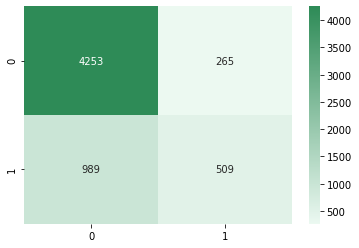

In [32]:
sns.heatmap(ret4dp[4], cmap=cmap, annot=True, fmt='g')

In [33]:
#For EQODDS
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, train_data, 10, opt)
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret4eqodds = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.1912514567375183 | 1.8188270330429077 | 1.2450727224349976 | 59863.703125 | 0.7548076923076923 | 0.649618700265252 | 42.268360411140584
> 2 | 0.14493544399738312 | 1.4260585308074951 | 0.9912521839141846 | 60106.1484375 | 0.7880056366047745 | 0.9374171087533156 | 11.269147877984086
> 3 | 0.13478700816631317 | 1.398311734199524 | 0.9939507246017456 | 59924.19921875 | 0.8006051061007957 | 0.9254807692307693 | 2.439157824933687
> 4 | 0.1434929519891739 | 1.3917174339294434 | 0.9612386226654053 | 59228.1484375 | 0.802304376657825 | 0.918808023872679 | 0.6219744694960212
> 5 | 0.054975807666778564 | 1.1022064685821533 | 0.9372790455818176 | 60817.0859375 | 0.8162301061007957 | 0.9430122679045093 | 17.943426724137932
> 6 | 0.05882680416107178 | 1.0969669818878174 | 0.920486569404602 | 60686.86328125 | 0.8254310344827587 | 0.9447944297082228 | 43.52652519893899
> 7 | 0.053784530609846115 | 1.093283

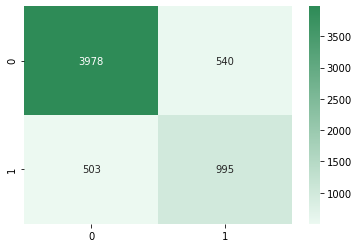

In [34]:
sns.heatmap(ret4eqodds[4], cmap=cmap, annot=True, fmt='g')

In [35]:
#For EQOPP
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, train_data, 10, opt)
Y_hat, A_hat, X_hat = validation(model, valid_data)
ret4eqopp = compute_metrics(y_valid, Y_hat, a_valid, A_hat, x_valid, X_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.17656457424163818 | 1.7848089933395386 | 1.255115270614624 | 59902.1328125 | 0.7937251326259946 | 0.7126989389920424 | 147.8267572944297
> 2 | -1.9453538656234741 | 1.7369872331619263 | 7.5730485916137695 | 59977.64453125 | 0.8085212201591512 | 0.8004807692307692 | 198.14348474801062
> 3 | 0.13477768003940582 | 1.7039755582809448 | 1.299642562866211 | 58776.94921875 | 0.7995275198938991 | 0.8010610079575597 | 223.37906167108753
> 4 | 0.23397938907146454 | 1.675362467765808 | 0.9734243154525757 | 58616.546875 | 0.8163129973474801 | 0.8558521220159151 | 214.06125663129973
> 5 | 0.246776282787323 | 1.6744219064712524 | 0.9340929985046387 | 57974.6796875 | 0.8192970822281167 | 0.945084549071618 | 182.65944131299736
> 6 | 0.25066033005714417 | 1.6682991981506348 | 0.9163181781768799 | 58129.7734375 | 0.8192141909814323 | 0.9454990053050398 | 185.0615053050398
> 7 | 0.25363555550575256 | 1.6672526

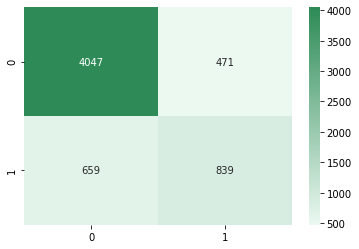

In [36]:
sns.heatmap(ret4eqopp[4], cmap=cmap, annot=True, fmt='g')

In [37]:
sns.set_style('darkgrid')

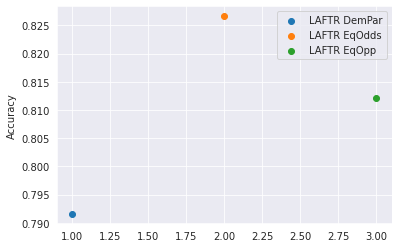

In [38]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_accs4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_accs4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_accs4deopp, ':', label = "LAFTR EOPP")
plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

y=[2,4,6]
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

plt.scatter(1, ret4dp[0], label = "LAFTR DemPar")

plt.scatter(2, ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(3, ret4eqopp[0], label = "LAFTR EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

In [39]:
'''plt.plot()
plt.ylabel('\u0394DP')

# plotting the line 1 points 
#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_dps4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_dps4deopp, ':', label = "LAFTR EOPP")

plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

'plt.plot()\nplt.ylabel(\'ΔDP\')\n\n# plotting the line 1 points \n#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")\n# line 2 points\n\n# plotting the line 2 points \nplt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")\nplt.plot(fair_coeff_list, unfair_dps4di, \'--\', label = "LAFTR EODD")\nplt.plot(fair_coeff_list, unfair_dps4deopp, \':\', label = "LAFTR EOPP")\n\nplt.xlabel(\'Fair coefficient\')\nplt.legend()\nplt.show()'

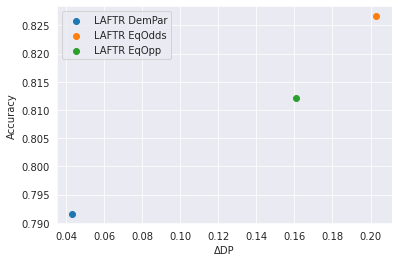

In [40]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dps4dp, sorted_unfair_accs_dps4dp, label = "LAFTR DP")
plt.plot(sorted_unfair_dps4di, sorted_unfair_accs_dps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_dps4deopp, sorted_unfair_accs_dps4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[1], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

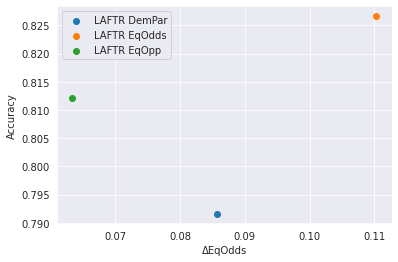

In [41]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dis4dp, sorted_unfair_accs_dis4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_dis4di, sorted_unfair_accs_dis4di, label = "LAFTR EODD")
plt.plot(sorted_unfair_dis4deopp, sorted_unfair_accs_dis4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394EOdds')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[2], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

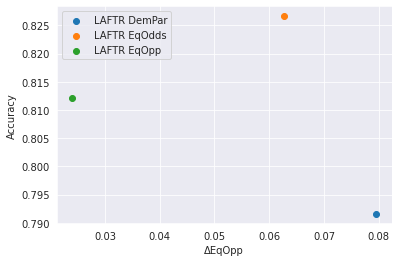

In [42]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points#

# plotting the line 2 points 
plt.plot(sorted_unfair_deopps4dp, sorted_unfair_accs_eopps4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_deopps4di, sorted_unfair_accs_eopps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_deopps4deopp, sorted_unfair_accs_eopps4deopp, label = "LAFTR EOPP")

plt.xlabel('\u0394EOpp')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[3], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()